In [1]:
import sys

sys.path.append("/home/fock/code/MultiModalInstructERC")


import json
import os

import numpy as np
import pandas as pd
from plotnine import (
    aes,
    geom_text,
    geom_tile,
    ggplot,
    scale_x_discrete,
    scale_y_discrete,
    theme,
    xlab,
    ylab,
)
from sklearn.metrics import confusion_matrix, f1_score

# Early concatination

# Early Summation

# Late Fusion (Summation)

**Auswertung auf IEMOCAP**

Zuerst werden die aktuellen Ergebnisse analysiert.
Die Ergebnisse von audio-only stammen aus dem mit nur auf audio vortrainiertem Modell, während text-only das finale Modell mit genulltem Audiosignal ist.
Fragen, die zu beantworten sind:
- Wie ist die Differenz zwischen text-/audio-only in der Klassifizierung?
  - Wie sicher war sich das Modell bei der klassifizierung?
  - kann das Modell Datenpunkte erkennen, die es nur mit beiden inputs richtig erkennt?
- wie ist der best mögliche F1 score, wenn das Modell 100% der beiden Teilmodelle ausnutzen könnte?
- Welche Klassen werden häufig verwechselt?
  - bei Text-only
  - bei Audio-only
- Gibt es besonderheiten in den Ausdrücken, wenn sie nur von Audio richtig klassifiziert werden?

In [2]:
base_path = "./results/late_fusion"

text_only_p = os.path.join(base_path, "preds_test_no_audio.json")
audio_only_p = os.path.join(base_path, "preds_test_no_text.json")
both_p = os.path.join(base_path, "preds_test.json")



with open(text_only_p, "rt") as f:
    text_only = json.load(f)

with open(audio_only_p, "rt") as f:
    audio_only = json.load(f)

with open(both_p, "rt") as f:
    both = json.load(f)

results = pd.DataFrame.from_records(text_only, index=["index"]).merge(
    pd.DataFrame.from_records(audio_only, index=["index", "input", "target"]),
    on=["index"],
    suffixes=["_text", "_audio"],
).merge(pd.DataFrame.from_records(both, index=["index", "input", "target"]), on=["index"], suffixes=["_both"])
assert len(results) == len(text_only)
results["utterance"] = results["input"].str.extract("<Speaker_\d: \"(.*?)\">")

import re


# from nltk.tokenize import word_tokenize
def get_dialog(prompt:str) -> tuple[list[str], set[str]]:
    base_prompt = "Now you are expert of sentiment and emotional analysis. The following conversation noted between '### ###' involves several speaker."
    prompt = prompt.replace(base_prompt, "")
    dialouge = re.findall(r"###(.*)###", prompt)[0].strip()
    dialog_text = re.findall(r"Speaker_\d:\s?\"(.*?)(?=\"\s?\t|\"\s?$)", dialouge, re.MULTILINE)
    involved_speakers = set(re.findall(r"(Speaker_\d)", dialouge))
    return dialog_text, involved_speakers

results["dialouge_length"] = results["input"].apply(lambda x: len(get_dialog(x)[0]))
results["utterence_length"] = results["utterance"].apply(lambda x: len(x.split()))

results

,input,output_text,target,certainty_text,output_audio,certainty_audio,output,certainty,utterance,dialouge_length,utterence_length
index,,,,,,,,,,,
0,Now you are expert of sentiment and emotional ...,frustrated,neutral,0.391113,neutral,0.483643,frustrated,0.412354,"Hi, I need an ID.",1,5
1,Now you are expert of sentiment and emotional ...,neutral,neutral,0.894043,frustrated,0.404297,neutral,0.879883,"ahh Yeah, this is the wrong line. I'm sorry. ...",2,26
2,Now you are expert of sentiment and emotional ...,frustrated,frustrated,0.907227,neutral,0.423340,frustrated,0.862793,"Okay, I'm sorry, but I just stood in this line...",3,21
3,Now you are expert of sentiment and emotional ...,frustrated,frustrated,0.952148,frustrated,0.486816,frustrated,0.920410,"No, they told me-I'm sorry, but they told me t...",5,14
4,Now you are expert of sentiment and emotional ...,frustrated,frustrated,0.953125,neutral,0.553711,frustrated,0.953613,"What, I mean what... what's the difference? W...",7,19
...,...,...,...,...,...,...,...,...,...,...,...
1617,Now you are expert of sentiment and emotional ...,angry,angry,0.945801,angry,0.909180,angry,0.973633,oh! Marry you again? I wouldn't marry you agai...,12,18
1618,Now you are expert of sentiment and emotional ...,angry,angry,0.955566,excited,0.545898,angry,0.942871,Beast,12,1
1619,Now you are expert of sentiment and emotional ...,angry,angry,0.955566,angry,0.937012,angry,0.978027,You're a wicked little vampire. And I pray to...,12,22


## Wie ist die Differenz zwischen text-/audio-only in der Klassifizierung?

In [3]:
text_only_correct = results[(results["output_text"] == results["target"]) & (results["output_audio"] != results["target"])]
audio_only_correct = results[(results["output_text"] != results["target"]) & (results["output_audio"] == results["target"])]
both_only_correct = results[(results["output"] == results["target"]) & (results["output_audio"] != results["target"]) & (results["output_text"] != results["target"])]
text_correct_but_not_both = results[(results["output_text"] == results["target"]) & (results["output"] != results["target"])]
audio_correct_but_not_both = results[(results["output_audio"] == results["target"]) & (results["output"] != results["target"])]
text_correct_but_not_audio_and_both = results[(results["output_text"] == results["target"]) & (results["output_audio"] != results["target"]) & (results["output"] != results["target"])]
audio_correct_but_not_text_and_both = results[(results["output_text"] != results["target"]) & (results["output_audio"] == results["target"]) & (results["output"] != results["target"])]

print(f"es konnten {len(text_only_correct)} Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only")
print(f"es konnten {len(audio_only_correct)} Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only")
print(f"es konnten {len(both_only_correct)} Datenpunkte nur durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(text_correct_but_not_both)} Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(audio_correct_but_not_both)} Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(text_correct_but_not_audio_and_both)} Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(audio_correct_but_not_text_and_both)} Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input erkannt werden")


es konnten 512 Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only
es konnten 172 Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only
es konnten 17 Datenpunkte nur durch gemeinsamen Input erkannt werden
es konnten 36 Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden
es konnten 125 Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden
es konnten 36 Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input erkannt werden
es konnten 125 Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input erkannt werden


Daraus lässt sich folgern:
- Audio-Input darf nicht vernachlässigt werden, da eine erhöhte Datenmenge nur von der Akustik korrekt klassifiziert werden konnte, nicht aber vom Text
- Es gibt Beispiele, wo nur durch gemeinsamen Input etwas korrekt erkannt werden konnte, diese Menge fällt aber vergleichsweise gering aus
- Text hat immernoch den größten Einfluss auf die Entschiedung des Modells, da nur 36 Beispiele im zusammenspiel mit der Akustik nicht mehr erkannt werden
- Audio wird stark unterdrückt. von den 172, die nur die Akustik erkannt werden konnten, werden 125 weiterhin nicht erkannt, wenn der Text hinzukommt.

## Idealer F1 Score
Dafür wird der F1 Score zwischen der Verknüpfung $(y_t = y) \vee (y_a = y) \vee (y_b = y)$ und $y$ berechnet.
Für die übrig bleibenden / überall falschen Felder, wird das Ergebnis vom gemischten Modell eingetragen. Dies hat aber keinen Einfluss auf den F1 Score

In [4]:
results["any_correct"] = results[(results["output_text"] == results["target"]) | (results["output_audio"] == results["target"]) | (results["output"] == results["target"])]["target"]
results.loc[results["any_correct"].isna(), "any_correct"] = results.loc[results["any_correct"].isna(), "output"]

ideal_f1 = f1_score(results["target"], results["any_correct"], average="weighted")

print(f"Idealer F1 Score: {ideal_f1:.3f}")

Idealer F1 Score: 0.808


Wäre das Modell in der Lage die Teilmodelle (Akustik- und Sprachmodell) perfekt einzusetzen, wäre ein theoretischer F1-Score von 0.808 möglich, angenommen keine weiteren Beispiele lassen sich nur durch gemeinsamen Input klassifizieren.

## Confusion Matrix

In [5]:
from plotnine import scale_color_manual, scale_fill_cmap


target_labels = results["target"].value_counts().index.to_list()[::-1]


def print_confusion_matrix(
    results: pd.DataFrame,
    target_labels: list[str] | None = None,
    output_column: str = "output",
) -> None:
    target_labels = (
        results["target"].unique() if target_labels is None else target_labels
    )
    cm = confusion_matrix(results["target"], results[output_column], labels=target_labels)
    cm_df = pd.DataFrame(cm, index=target_labels, columns=target_labels)
    cm_melted = cm_df.reset_index().melt(id_vars="index", value_name="count")
    cm_melted.columns = ["actual", "predicted", "count"]
    cm_melted["actual"] = pd.Categorical(cm_melted["actual"], categories=target_labels)
    cm_melted["predicted"] = pd.Categorical(
        cm_melted["predicted"], categories=target_labels
    )

    # Calculate total counts for each actual class
    total_counts = cm_melted.groupby("actual")["count"].sum().reset_index()
    total_counts.columns = ["actual", "total_count"]

    # Merge total counts back to the melted DataFrame
    cm_melted = cm_melted.merge(total_counts, on="actual")

    # Calculate the fraction
    cm_melted["sqrt_fraction"] = np.sqrt(cm_melted["count"]) / np.sqrt(cm_melted["total_count"])
    cm_melted["fraction"] = (cm_melted["count"] / cm_melted["total_count"]).round(2)
    cm_melted["label"] = cm_melted["count"].astype(str) + " (" + cm_melted["fraction"].astype(str) + ")"
    cm_melted["p_group"] = cm_melted["fraction"].apply(lambda x: "high" if x > 0.5 else "low")

    p = (
        ggplot(cm_melted, aes("factor(predicted)", "factor(actual)", fill="sqrt_fraction"))
        + geom_tile(show_legend=False)
        + geom_text(aes(label="label", color="p_group"), size=8, show_legend=False)
        + xlab("Predicted")
        + ylab("True")
        + scale_x_discrete(limits=target_labels[::-1])
        + scale_fill_cmap(cmap_name="magma")
        + scale_color_manual(["black", "white"])
    )

    p.show()

Die Confusion Matrix enthät neben der absoluten Anzahl auch das Verhältnis in der entsprechenden Reihe

**Confusion Matrix vom text-only Modell**

/tmp/ipykernel_1316415/2693533925.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


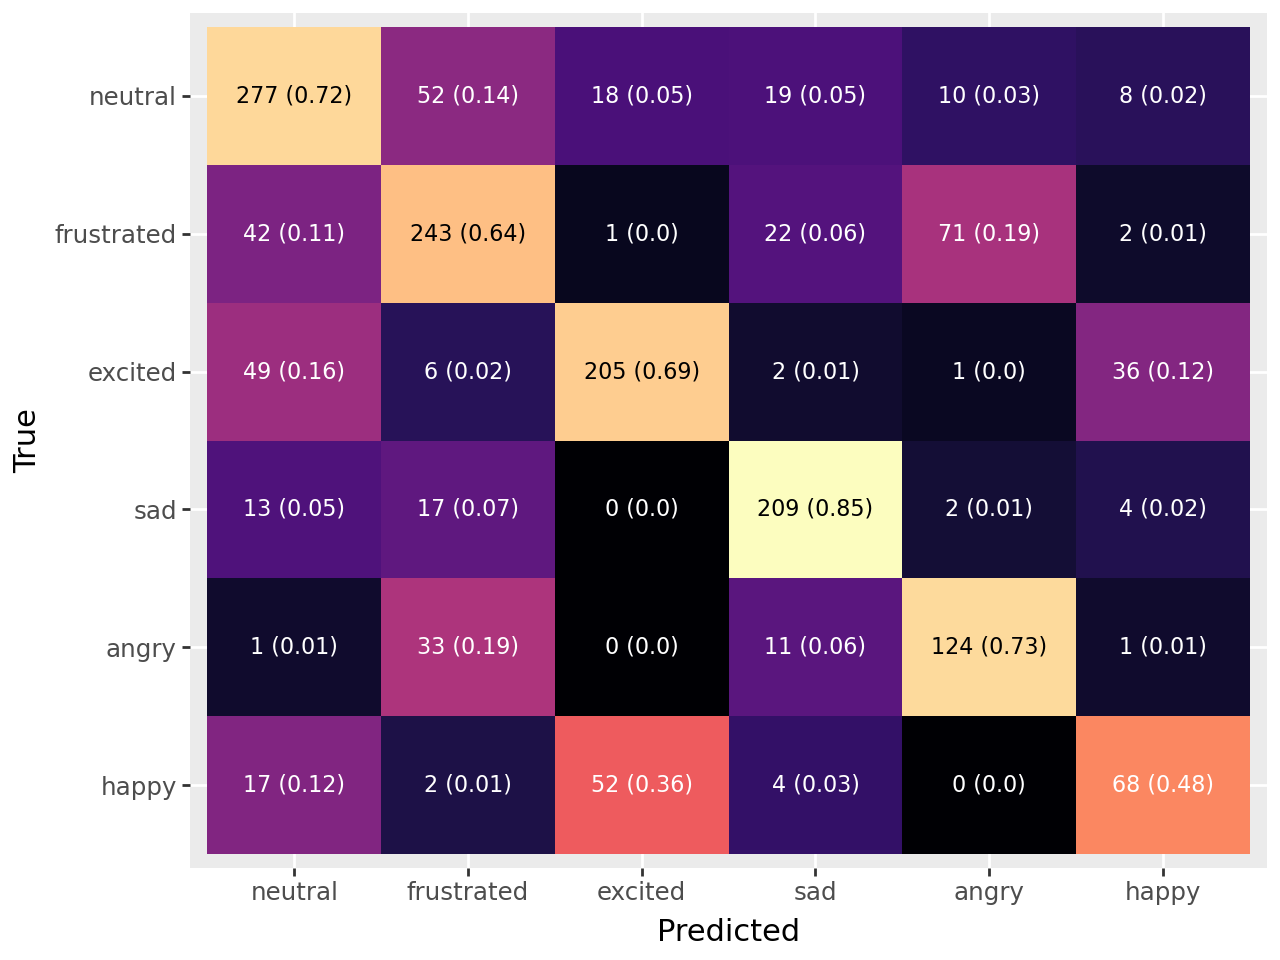

In [6]:
print_confusion_matrix(results, target_labels, output_column="output_text")

- Die meisten verwechselungen gibt es mit "neutral"
- Nah beieinander liegende Emotionen werden oft verwechselt
  - "happy" mit "excited"
  - "frustrated" mit "angry"

**Confisuin Matrix vom audio-only Modell**

/tmp/ipykernel_1316415/2693533925.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


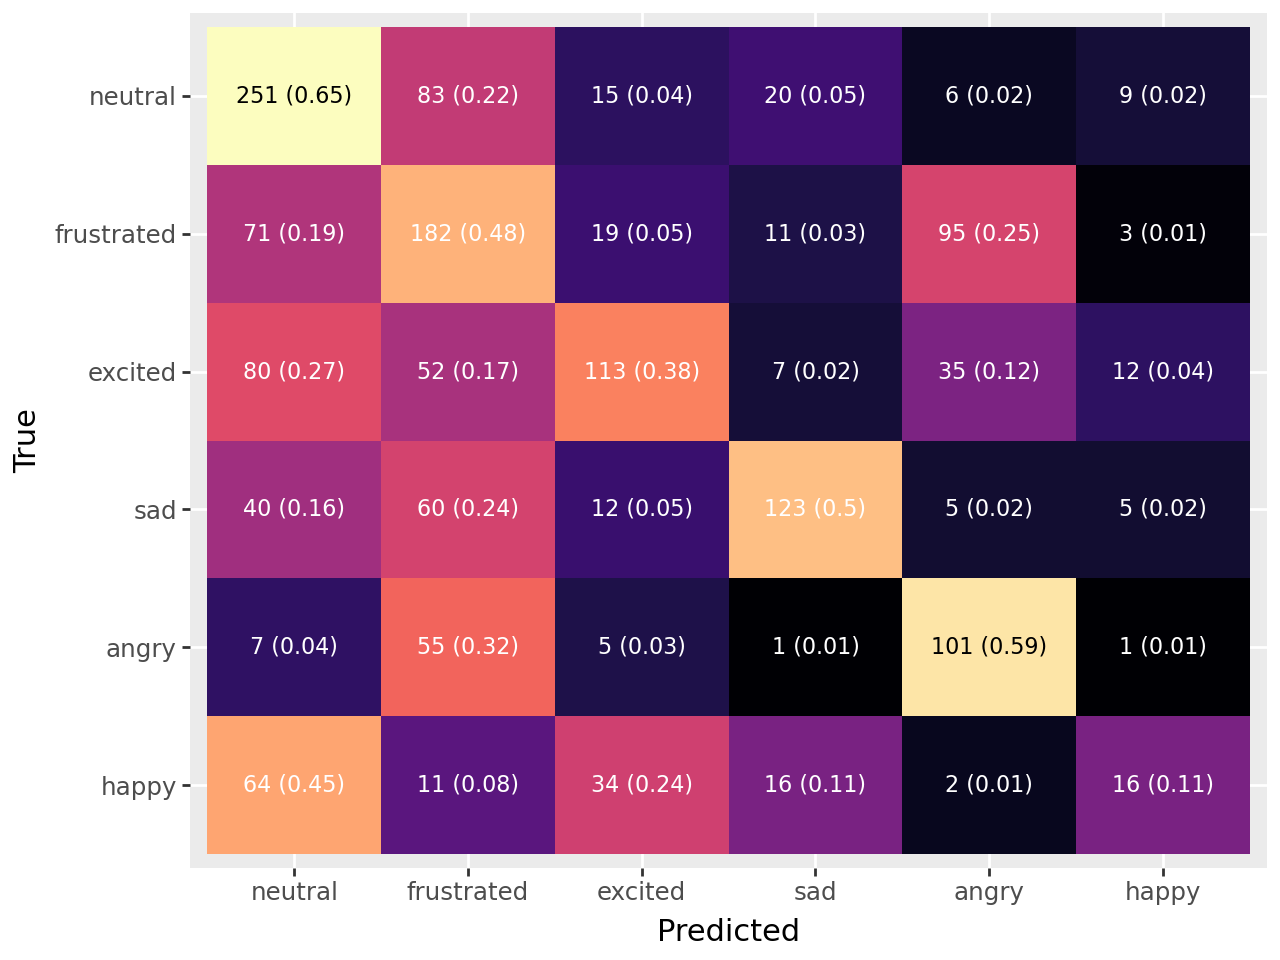

In [7]:
print_confusion_matrix(results, target_labels, output_column="output_audio")

Hier stellt sich ein ähnliches Bild, wie beim text ein, nur, dass die Werte stärker verteilt sind (niedrigerer F1)

## Gibt es besonderheiten in den Ausdrücken, wenn sie nur von Audio richtig klassifiziert werden?
Diese Frage zielt darauf ab, ob man im vorhinein erkennen kann, ob die Klassifizierung mittels Audio oder Text vielversprechender ist

**Verteilung der Dialoglängen**

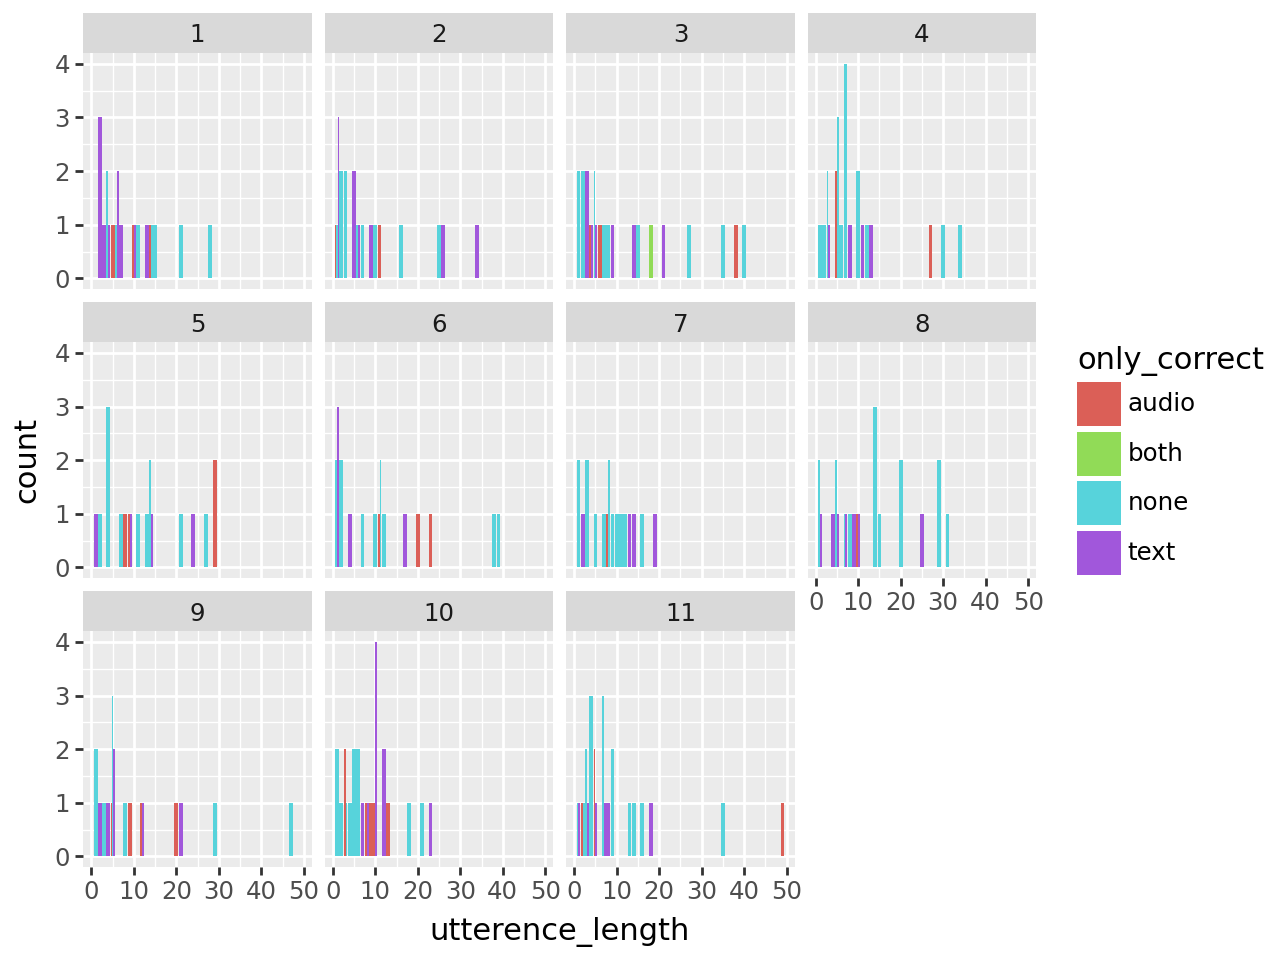

In [8]:
from plotnine import facet_wrap, geom_density, geom_histogram

results.loc[text_only_correct.index, "only_correct"] = "text"
results.loc[audio_only_correct.index, "only_correct"] = "audio"
results.loc[both_only_correct.index, "only_correct"] = "both"
results["only_correct"] = results["only_correct"].fillna("none")

(
    ggplot(results[(results["dialouge_length"] < 12) & (results["utterence_length"] < 50)].dropna(), aes(x="utterence_length", fill="only_correct")) +
    geom_histogram(stat="count", position="dodge") + 
    # geom_density(stat="count", alpha=0.33) + 
    facet_wrap("dialouge_length")
)



In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoProcessor
from peft import PeftModel
from torch.utils.data import DataLoader

from utils.collator import SequenceClassificationCollator
from utils.dataset import IemocapDataset

from tqdm.auto import tqdm

llm_path = "../../models/language/LLaMA2-base"
ae_path = "../../models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim"
adapter_path = "../../models/language/adapter/iemocap/LLaMA2-base"
dataset_path = "../../datasets/iemocap/iemocap.csv"

In [10]:
# llama = AutoModelForCausalLM.from_pretrained(
#     llm_path,
# ).half()
# llama = PeftModel.from_pretrained(llama, adapter_path)
# llama = llama.merge_and_unload(progressbar=True)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Unloading and merging model: 100%|██████████| 550/550 [00:03<00:00, 176.48it/s]


In [11]:
from utils.processor import MmLlamaProcessor
import torch

tokenizer = AutoTokenizer.from_pretrained(llm_path)
tokenizer.pad_token_id = tokenizer.unk_token_id
tokenizer.padding_side = "left"

ac_processor = AutoProcessor.from_pretrained(ae_path)

processor = MmLlamaProcessor(ac_processor, tokenizer)

train_dataset = IemocapDataset(
    dataset_path,
    mode="test",
    task="normal",
    window=12,
    audio_placement="none",
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=8,
    collate_fn=SequenceClassificationCollator(processor, train_dataset),
)

def prepare_batch(batch: dict[str, dict[str, torch.Tensor] | torch.Tensor]):
    for k in batch:
        if type(batch[k]) is torch.Tensor:
            batch[k] = batch[k].cuda()
            continue
        for kk in batch[k]:
            batch[k][kk] = batch[k][kk].cuda()
        
    return batch

# llama.cuda()
# llama.eval()
# hidden_states = []
# with torch.no_grad():
#     for batch in tqdm(train_dataloader):
#         text = prepare_batch(batch["text"])
#         out = llama(**text, output_hidden_states=True).hidden_states[25]
#         hidden_states.extend(out.cpu())
# torch.save(hidden_states, "hidden_states.pt")

In [15]:
class DecisionModel(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.down_proj = torch.nn.Linear(hidden_size, 256)
        self.mha = torch.nn.MultiheadAttention(256, 1, batch_first=True, dropout=0.5)
        self.hidden = torch.nn.Linear(256, 256)
        self.fc = torch.nn.Linear(256, 3)
        self.ac = torch.nn.SiLU()
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.down_proj(x)
        x = self.mha(x, x, x)[0]
        x = self.dropout(x)
        x = self.ac(self.hidden(x))
        x = torch.mean(x, dim=1)
        x = self.fc(x)
        return x


class AggregateCollator(object):
    def __call__(self, batch):
        hs, y = zip(*batch)

        max_len = max(list(map(lambda x: x.shape[0], hs)))
        hs = torch.stack(
            list(
                map(
                    lambda x: torch.cat(
                        [x, torch.zeros(max_len - x.shape[0], x.shape[1])], dim=0
                    ),
                    hs,
                )
            )
        )

        y_map = {"audio": 0, "text": 1, "both": 2, "none": 0.5}
        y = list(map(lambda x: y_map[x], y))
        return {"inputs":hs, "labels":torch.tensor(y).long()}


hidden_states = torch.load("hidden_states.pt")
hidden_states = [x for hs in hidden_states for x in hs]

model = DecisionModel(hidden_states[0].shape[-1]).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

inputs = list(zip(hidden_states, results["only_correct"]))
filtered_inputs = list(filter(lambda x: x[1] != "none", inputs))
train_inputs = filtered_inputs[: int(len(filtered_inputs) * 0.8)]
val_inputs = filtered_inputs[int(len(filtered_inputs) * 0.8) :]

print(len(train_inputs), len(val_inputs))


d_dataloader = DataLoader(
    train_inputs,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=AggregateCollator(),
)
d_val_dataloader = DataLoader(
    val_inputs,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=AggregateCollator(),
)

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([3.0, 1.0, 1.0]))

for i in tqdm(range(41)):
    i += 1
    running_loss = 0
    model.train()
    for batch in d_dataloader:
        batch = prepare_batch(batch)
        hs, only_correct = batch["inputs"], batch["labels"]
        pred = model(hs)
        print(pred.device, only_correct.device)
        loss = criterion(pred, only_correct)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i % 2 == 0:
        eval_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in d_val_dataloader:
                batch = prepare_batch(batch)
                hs, only_correct = batch["inputs"], batch["labels"]
                pred = model(hs)
                loss = criterion(pred, only_correct)
                eval_loss += loss.item()
        print(
            "Epoch",
            i,
            "Train Loss",
            running_loss / len(d_dataloader),
            "Eval Loss",
            eval_loss / len(d_val_dataloader),
        )

560 141


  0%|          | 0/41 [00:00<?, ?it/s]

KeyboardInterrupt: 

: 

In [ ]:
with torch.no_grad():
    x,y = next(iter(d_val_dataloader))
    pred = model(x)
    print(pred)
    print(y)

tensor([[0.7022],
        [0.7299],
        [0.7468],
        [0.5568],
        [0.5697],
        [0.5658],
        [0.5527],
        [0.5689],
        [0.5980],
        [0.6069],
        [0.5603],
        [0.6120],
        [0.5777],
        [0.6400],
        [0.6916],
        [0.7405],
        [0.6826],
        [0.6925],
        [0.7017],
        [0.7041],
        [0.6994],
        [0.6538],
        [0.6424],
        [0.6243],
        [0.6561],
        [0.6559],
        [0.6783],
        [0.6071],
        [0.6222],
        [0.6698],
        [0.6631],
        [0.6791]])
tensor([0.0000, 0.0000, 1.0000, 1.0000, 0.5000, 0.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.5000, 1.0000, 1.0000])
